In [1]:
import pandas as pd
import numpy as np
df=pd.read_csv(r'/home/saswata/data_science/UM_projects/world_population/world_population.csv')
df

,Rank,CCA3,Country/Territory,Capital,Continent,2022 Population,2020 Population,2015 Population,2010 Population,2000 Population,1990 Population,1980 Population,1970 Population,Area (km²),Density (per km²),Growth Rate,World Population Percentage
0,36,AFG,Afghanistan,Kabul,Asia,41128771,38972230,33753499,28189672,19542982,10694796,12486631,10752971,652230,63.0587,1.0257,0.52
1,138,ALB,Albania,Tirana,Europe,2842321,2866849,2882481,2913399,3182021,3295066,2941651,2324731,28748,98.8702,0.9957,0.04
2,34,DZA,Algeria,Algiers,Africa,44903225,43451666,39543154,35856344,30774621,25518074,18739378,13795915,2381741,18.8531,1.0164,0.56
3,213,ASM,American Samoa,Pago Pago,Oceania,44273,46189,51368,54849,58230,47818,32886,27075,199,222.4774,0.9831,0.00
4,203,AND,Andorra,Andorra la Vella,Europe,79824,77700,71746,71519,66097,53569,35611,19860,468,170.5641,1.0100,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,226,WLF,Wallis and Futuna,Mata-Utu,Oceania,11572,11655,12182,13142,14723,13454,11315,9377,142,81.4930,0.9953,0.00
230,172,ESH,Western Sahara,El Aaiún,Africa,575986,556048,491824,413296,270375,178529,116775,76371,266000,2.1654,1.0184,0.01
231,46,YEM,Yemen,Sanaa,Asia,33696614,32284046,28516545,24743946,18628700,13375121,9204938,6843607,527968,63.8232,1.0217,0.42
232,63,ZMB,Zambia,Lusaka,Africa,20017675,18927715,16248230,13792086,9891136,7686401,5720438,4281671,752612,26.5976,1.0280,0.25


In [2]:
import pandas as pd

# --- Melt the Data ---
pop_cols = [col for col in df.columns if 'Population' in col and 'World' not in col]
df_melted = df.melt(
    id_vars=['Country/Territory', 'Area (km²)', 'Growth Rate'],
    value_vars=pop_cols,
    var_name='Year',
    value_name='Population'
)
df_melted['Year'] = df_melted['Year'].str.extract(r'(\d{4})').astype(int)
df_melted['Date'] = pd.to_datetime(df_melted['Year'].astype(str) + '-01-01')  # Set date as 1st Jan of each year
df_melted.sort_values(by=['Country/Territory', 'Date'], inplace=True)

# --- Feature Engineering ---
df_melted['Density'] = df_melted['Population'] / df_melted['Area (km²)']

# Initialize Growth and Growth Rate Δ with NaN
df_melted['Growth'] = pd.NA

# Set Growth and Growth Rate Δ for the first year (1970) as 0
df_melted.loc[df_melted['Year'] == 1970, 'Growth'] = 0

# Calculate Growth and Growth Rate Δ, starting from 1971 (second year)
for country in df_melted['Country/Territory'].unique():
    country_df = df_melted[df_melted['Country/Territory'] == country].sort_values(by='Year').copy()
    
    # Calculate Growth (change in population relative to previous year) and Growth Rate Δ (difference of Growth)
    for i in range(1, len(country_df)):
        current_year = country_df.iloc[i]
        previous_year = country_df.iloc[i-1]
        
        # Calculate Growth Rate (change in population from previous year to current year)
        growth_rate = (current_year['Population'] - previous_year['Population']) / previous_year['Population']
        df_melted.loc[(df_melted['Country/Territory'] == country) & (df_melted['Year'] == current_year['Year']), 'Growth'] = growth_rate
        


# --- Extrapolation for 1970 ---
# After calculating growth for subsequent years, we can extrapolate growth for the first year.
# We'll simply carry forward the second year’s growth and growth rate change to the first year.

for country in df_melted['Country/Territory'].unique():
    country_df = df_melted[df_melted['Country/Territory'] == country].copy()
    
    # Extrapolate growth and rate of change of growth rate from second year to the first year
    if 1971 in country_df['Year'].values:
        growth_2nd_year = country_df[country_df['Year'] == 1971]['Growth'].values[0]
        
        # Extrapolate using 2nd year's values for the first year
        df_melted.loc[(df_melted['Country/Territory'] == country) & (df_melted['Year'] == 1970), 'Growth'] = growth_2nd_year

df_melted.head(20)

,Country/Territory,Area (km²),Growth Rate,Year,Population,Date,Density,Growth
1638,Afghanistan,652230,1.0257,1970,10752971,1970-01-01,16.486471,0
1404,Afghanistan,652230,1.0257,1980,12486631,1980-01-01,19.144521,0.161226
1170,Afghanistan,652230,1.0257,1990,10694796,1990-01-01,16.397277,-0.1435
936,Afghanistan,652230,1.0257,2000,19542982,2000-01-01,29.963329,0.827336
702,Afghanistan,652230,1.0257,2010,28189672,2010-01-01,43.220447,0.442445
468,Afghanistan,652230,1.0257,2015,33753499,2015-01-01,51.750915,0.197371
234,Afghanistan,652230,1.0257,2020,38972230,2020-01-01,59.752281,0.154613
0,Afghanistan,652230,1.0257,2022,41128771,2022-01-01,63.058692,0.055335
1639,Albania,28748,0.9957,1970,2324731,1970-01-01,80.865834,0
1405,Albania,28748,0.9957,1980,2941651,1980-01-01,102.325414,0.265373


In [3]:
all_years = pd.DataFrame({'Year': range(1970, 2023)})
interpolated_dfs = []

for country in df_melted['Country/Territory'].unique():
    country_df = df_melted[df_melted['Country/Territory'] == country].copy()

    merged = pd.merge(all_years, country_df, on='Year', how='left')
    merged['Country/Territory'] = country
    merged['Area (km²)'] = merged['Area (km²)'].ffill()

    # Interpolate population
    merged['Population'] = merged['Population'].interpolate(method='linear')

    # Recompute Date and Density
    merged['Date'] = pd.to_datetime(merged['Year'].astype(str) + '-01-01')
    merged['Density'] = merged['Population'] / merged['Area (km²)']

    # Recompute Growth as % change
    merged['Growth'] = merged['Population'].pct_change()
    merged.loc[0, 'Growth'] = merged.loc[1, 'Growth']  # Extrapolate first year

    interpolated_dfs.append(merged)

df_full = pd.concat(interpolated_dfs, ignore_index=True)
df_full.sort_values(by=['Country/Territory', 'Year'], inplace=True)

df_full

,Year,Country/Territory,Area (km²),Growth Rate,Population,Date,Density,Growth
0,1970,Afghanistan,652230.0,1.0257,10752971.0,1970-01-01,16.486471,0.016123
1,1971,Afghanistan,652230.0,NaN,10926337.0,1971-01-01,16.752276,0.016123
2,1972,Afghanistan,652230.0,NaN,11099703.0,1972-01-01,17.018081,0.015867
3,1973,Afghanistan,652230.0,NaN,11273069.0,1973-01-01,17.283886,0.015619
4,1974,Afghanistan,652230.0,NaN,11446435.0,1974-01-01,17.549691,0.015379
...,...,...,...,...,...,...,...,...
12397,2018,Zimbabwe,390757.0,NaN,15063774.4,2018-01-01,38.550236,0.020524
12398,2019,Zimbabwe,390757.0,NaN,15366720.2,2019-01-01,39.325515,0.020111
12399,2020,Zimbabwe,390757.0,1.0204,15669666.0,2020-01-01,40.100794,0.019714
12400,2021,Zimbabwe,390757.0,NaN,15995101.5,2021-01-01,40.933628,0.020769


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Parameters
seq_len = 5
n_future = 10

results = []

for country in df_full['Country/Territory'].unique():
    df_country = df_full[df_full['Country/Territory'] == country][['Year', 'Population', 'Area (km²)']].dropna()
    
    if len(df_country) <= seq_len:
        continue  # not enough data

    area = df_country['Area (km²)'].iloc[0]

    scaler = MinMaxScaler()
    population_scaled = scaler.fit_transform(df_country[['Population']])

    # Sequence creator
    def create_sequences(data, seq_length=5):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)

    X, y = create_sequences(population_scaled, seq_len)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # LSTM model
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(seq_len, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=100, verbose=0)

    # Forecasting
    last_seq = population_scaled[-seq_len:]
    predictions = []

    for _ in range(n_future):
        pred = model.predict(last_seq.reshape(1, seq_len, 1), verbose=0)[0][0]
        predictions.append(pred)
        last_seq = np.append(last_seq[1:], [[pred]], axis=0)

    # Inverse scale predictions
    pred_scaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    future_years = np.arange(df_country['Year'].max() + 1, df_country['Year'].max() + 1 + n_future)

    df_future = pd.DataFrame({
        'Country/Territory': country,
        'Year': future_years,
        'Population': pred_scaled.flatten(),
        'Area (km²)': area
    })
    df_future['Density'] = df_future['Population'] / area

    results.append(df_future)

# Combine all countries' future predictions
df_lstm = pd.concat(results, ignore_index=True)


2025-04-13 22:23:42.378541: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-13 22:23:43.928988: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
df_lstm

,Country/Territory,Year,Population,Area (km²),Density
0,Afghanistan,2023,43290952.0,652230.0,66.373749
1,Afghanistan,2024,44864528.0,652230.0,68.786362
2,Afghanistan,2025,46648516.0,652230.0,71.521576
3,Afghanistan,2026,48714840.0,652230.0,74.689667
4,Afghanistan,2027,51152212.0,652230.0,78.426643
...,...,...,...,...,...
2335,Zimbabwe,2028,19863932.0,390757.0,50.834488
2336,Zimbabwe,2029,20761626.0,390757.0,53.131809
2337,Zimbabwe,2030,21830884.0,390757.0,55.868183
2338,Zimbabwe,2031,23125742.0,390757.0,59.181900


In [14]:
import pandas as pd

# Step 1: Calculate Growth in df_lstm
df_lstm['Growth'] = 0.0

for country in df_lstm['Country/Territory'].unique():
    c_df = df_lstm[df_lstm['Country/Territory'] == country].sort_values('Year').copy()
    for i in range(1, len(c_df)):
        prev_pop = c_df.iloc[i-1]['Population']
        curr_pop = c_df.iloc[i]['Population']
        growth = (curr_pop - prev_pop) / prev_pop
        df_lstm.loc[c_df.index[i], 'Growth'] = growth

# Step 2: Drop 'Growth Rate' and 'Date' from df_full
df_full_cleaned = df_full.drop(columns=['Growth Rate', 'Date'])

# Step 3: Merge/concat both DataFrames
df_merged = pd.concat([df_full_cleaned, df_lstm], ignore_index=True)

# Recalculate Growth in merged DataFrame for missing or zero values
df_merged.sort_values(by=['Country/Territory', 'Year'], inplace=True)

for country in df_merged['Country/Territory'].unique():
    c_df = df_merged[df_merged['Country/Territory'] == country]
    for i in range(1, len(c_df)):
        idx = c_df.index[i]
        prev_idx = c_df.index[i - 1]
        if df_merged.loc[idx, 'Growth'] in [0, None, float('nan')]:
            prev_pop = df_merged.loc[prev_idx, 'Population']
            curr_pop = df_merged.loc[idx, 'Population']
            if prev_pop > 0:
                df_merged.loc[idx, 'Growth'] = (curr_pop - prev_pop) / prev_pop

df_merged.iloc[40:80]

,Year,Country/Territory,Area (km²),Population,Density,Growth
40,2010,Afghanistan,652230.0,28189672.0,43.220447,0.031644
41,2011,Afghanistan,652230.0,29302437.4,44.926540,0.039474
42,2012,Afghanistan,652230.0,30415202.8,46.632634,0.037975
43,2013,Afghanistan,652230.0,31527968.2,48.338727,0.036586
44,2014,Afghanistan,652230.0,32640733.6,50.044821,0.035295
45,2015,Afghanistan,652230.0,33753499.0,51.750915,0.034091
46,2016,Afghanistan,652230.0,34797245.2,53.351188,0.030923
47,2017,Afghanistan,652230.0,35840991.4,54.951461,0.029995
48,2018,Afghanistan,652230.0,36884737.6,56.551734,0.029122
49,2019,Afghanistan,652230.0,37928483.8,58.152007,0.028298


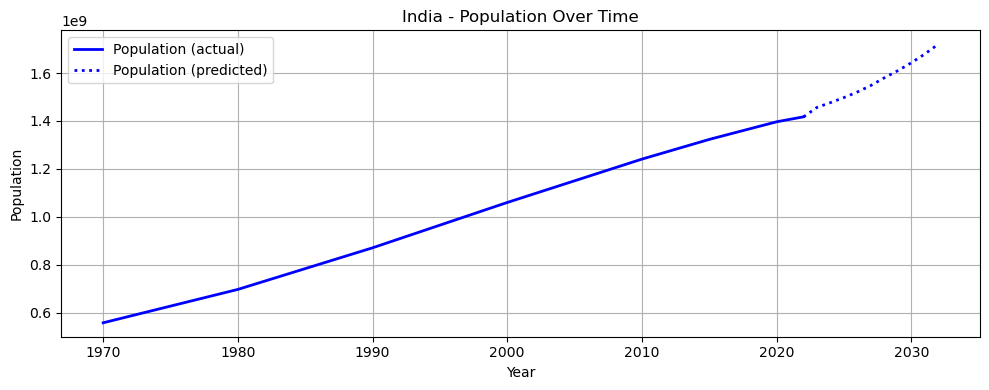

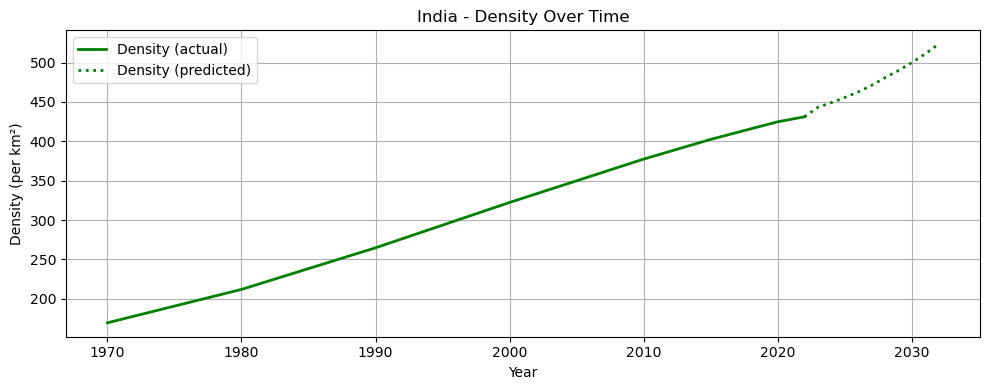

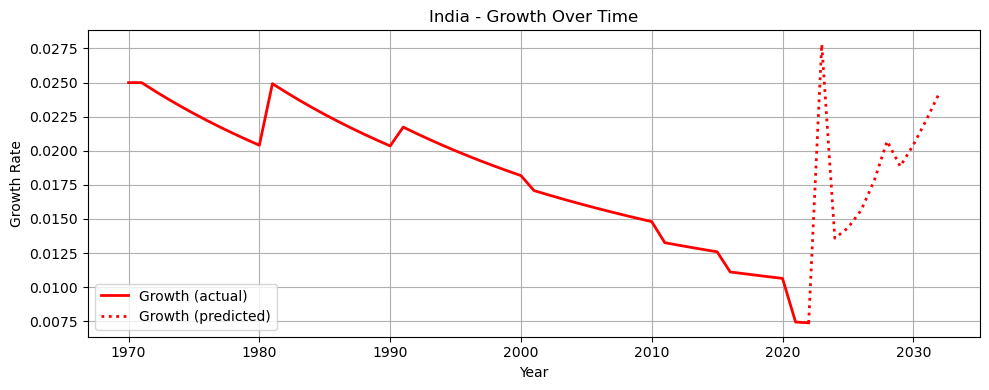

In [15]:
import matplotlib.pyplot as plt

# Filter India data
india_df = df_merged[df_merged['Country/Territory'] == 'India'].sort_values(by='Year')
india_actual = india_df[india_df['Year'] <= 2022]
india_pred = india_df[india_df['Year'] >= 2022]

# Plot Population
plt.figure(figsize=(10, 4))
plt.plot(india_actual['Year'], india_actual['Population'], color='blue', label='Population (actual)', linewidth=2)
plt.plot(india_pred['Year'], india_pred['Population'], color='blue', linestyle='dotted', label='Population (predicted)', linewidth=2)
plt.title('India - Population Over Time')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Density
plt.figure(figsize=(10, 4))
plt.plot(india_actual['Year'], india_actual['Density'], color='green', label='Density (actual)', linewidth=2)
plt.plot(india_pred['Year'], india_pred['Density'], color='green', linestyle='dotted', label='Density (predicted)', linewidth=2)
plt.title('India - Density Over Time')
plt.xlabel('Year')
plt.ylabel('Density (per km²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Growth
plt.figure(figsize=(10, 4))
plt.plot(india_actual['Year'], india_actual['Growth'], color='red', label='Growth (actual)', linewidth=2)
plt.plot(india_pred['Year'], india_pred['Growth'], color='red', linestyle='dotted', label='Growth (predicted)', linewidth=2)
plt.title('India - Growth Over Time')
plt.xlabel('Year')
plt.ylabel('Growth Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Parameters
seq_len = 5
n_future = 10

results = []

for country in df_full['Country/Territory'].unique():
    df_country = df_full[df_full['Country/Territory'] == country][['Year', 'Population', 'Area (km²)', 'Growth']].dropna()
    
    if len(df_country) <= seq_len:
        continue

    area = df_country['Area (km²)'].iloc[0]
    last_pop = df_country[df_country['Year'] == 2022]['Population'].values[0]

    # Scale Growth
    scaler = MinMaxScaler()
    growth_scaled = scaler.fit_transform(df_country[['Growth']])

    # Create sequences
    def create_sequences(data, seq_length=5):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)

    X, y = create_sequences(growth_scaled, seq_len)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # LSTM model
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(seq_len, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=100, verbose=0)

    # Forecasting growth
    last_seq = growth_scaled[-seq_len:]
    growth_preds = []

    for _ in range(n_future):
        pred = model.predict(last_seq.reshape(1, seq_len, 1), verbose=0)[0][0]
        growth_preds.append(pred)
        last_seq = np.append(last_seq[1:], [[pred]], axis=0)

    growth_preds = scaler.inverse_transform(np.array(growth_preds).reshape(-1, 1)).flatten()

    # Calculate Population and Density using Growth
    populations = []
    densities = []
    pop = last_pop

    for g in growth_preds:
        pop = pop * (1 + g / 100)
        populations.append(pop)
        densities.append(pop / area)

    future_years = np.arange(2023, 2023 + n_future)
    df_future = pd.DataFrame({
        'Country/Territory': country,
        'Year': future_years,
        'Growth': growth_preds,
        'Population': populations,
        'Area (km²)': area,
        'Density': densities
    })

    results.append(df_future)

# Final combined dataframe
df_lstm2 = pd.concat(results, ignore_index=True)


In [12]:
df_lstm2

,Country/Territory,Year,Growth,Population,Area (km²),Density
0,Afghanistan,2023,0.024018,4.113865e+07,652230.0,63.073838
1,Afghanistan,2024,0.023219,4.114820e+07,652230.0,63.088483
2,Afghanistan,2025,0.022453,4.115744e+07,652230.0,63.102648
3,Afghanistan,2026,0.021713,4.116638e+07,652230.0,63.116350
4,Afghanistan,2027,0.020871,4.117497e+07,652230.0,63.129523
...,...,...,...,...,...,...
2335,Zimbabwe,2028,0.019016,1.633956e+07,390757.0,41.815140
2336,Zimbabwe,2029,0.018879,1.634264e+07,390757.0,41.823035
2337,Zimbabwe,2030,0.018745,1.634571e+07,390757.0,41.830874
2338,Zimbabwe,2031,0.018623,1.634875e+07,390757.0,41.838664


In [16]:
import pandas as pd

# Step 1: Clean original full dataframe
df_full_cleaned = df_full.drop(columns=['Growth Rate', 'Date'])

# Step 2: Concatenate df_full_cleaned and df_lstm2
df_merged2 = pd.concat([df_full_cleaned, df_lstm2], ignore_index=True)

# Step 3: Sort by country and year
df_merged2.sort_values(by=['Country/Territory', 'Year'], inplace=True)
df_merged2.reset_index(drop=True, inplace=True)


In [17]:
df_merged2.iloc[40:70]

,Year,Country/Territory,Area (km²),Population,Density,Growth
40,2010,Afghanistan,652230.0,2.818967e+07,43.220447,0.031644
41,2011,Afghanistan,652230.0,2.930244e+07,44.926540,0.039474
42,2012,Afghanistan,652230.0,3.041520e+07,46.632634,0.037975
43,2013,Afghanistan,652230.0,3.152797e+07,48.338727,0.036586
44,2014,Afghanistan,652230.0,3.264073e+07,50.044821,0.035295
45,2015,Afghanistan,652230.0,3.375350e+07,51.750915,0.034091
46,2016,Afghanistan,652230.0,3.479725e+07,53.351188,0.030923
47,2017,Afghanistan,652230.0,3.584099e+07,54.951461,0.029995
48,2018,Afghanistan,652230.0,3.688474e+07,56.551734,0.029122
49,2019,Afghanistan,652230.0,3.792848e+07,58.152007,0.028298


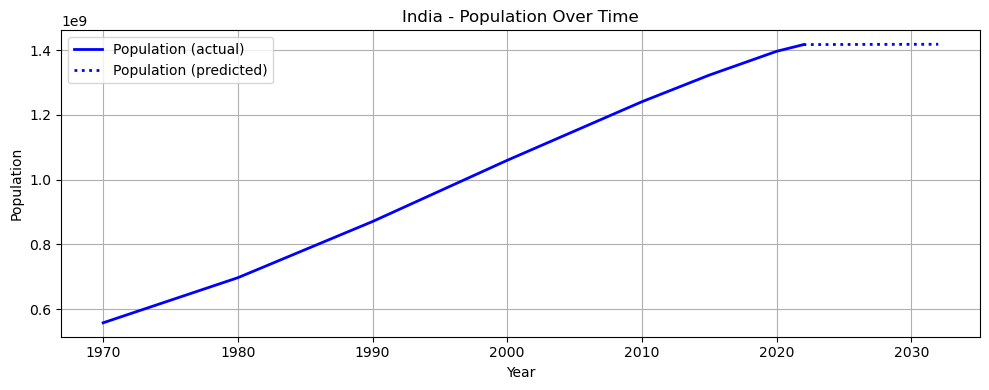

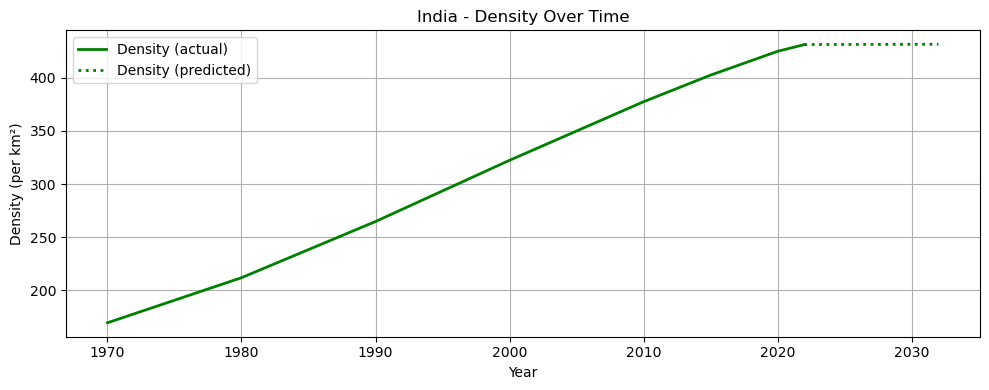

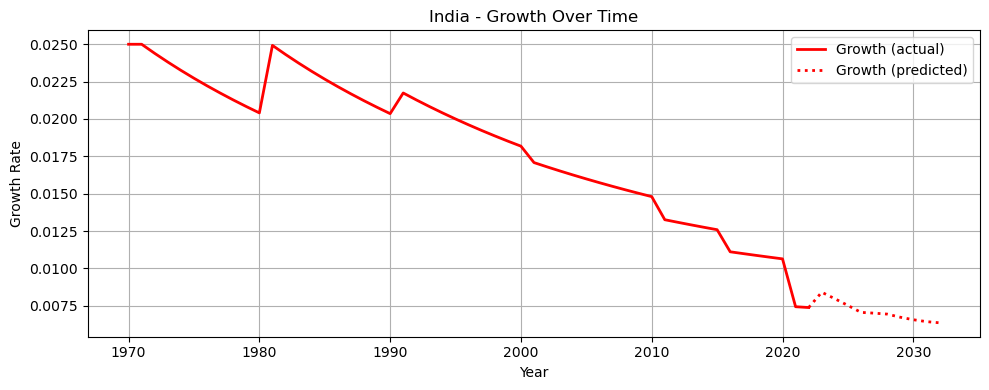

In [18]:
import matplotlib.pyplot as plt

# Filter India data
india_df = df_merged2[df_merged2['Country/Territory'] == 'India'].sort_values(by='Year')
india_actual = india_df[india_df['Year'] <= 2022]
india_pred = india_df[india_df['Year'] >= 2022]

# Plot Population
plt.figure(figsize=(10, 4))
plt.plot(india_actual['Year'], india_actual['Population'], color='blue', label='Population (actual)', linewidth=2)
plt.plot(india_pred['Year'], india_pred['Population'], color='blue', linestyle='dotted', label='Population (predicted)', linewidth=2)
plt.title('India - Population Over Time')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Density
plt.figure(figsize=(10, 4))
plt.plot(india_actual['Year'], india_actual['Density'], color='green', label='Density (actual)', linewidth=2)
plt.plot(india_pred['Year'], india_pred['Density'], color='green', linestyle='dotted', label='Density (predicted)', linewidth=2)
plt.title('India - Density Over Time')
plt.xlabel('Year')
plt.ylabel('Density (per km²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Growth
plt.figure(figsize=(10, 4))
plt.plot(india_actual['Year'], india_actual['Growth'], color='red', label='Growth (actual)', linewidth=2)
plt.plot(india_pred['Year'], india_pred['Growth'], color='red', linestyle='dotted', label='Growth (predicted)', linewidth=2)
plt.title('India - Growth Over Time')
plt.xlabel('Year')
plt.ylabel('Growth Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()